### Import das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Import dos dados

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
seoul_bike_sharing_demand = fetch_ucirepo(id=560) 
  
# data (as pandas dataframes) 
X = seoul_bike_sharing_demand.data.features 
y = seoul_bike_sharing_demand.data.targets 



In [4]:
df = pd.concat([X, y], axis=1)
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### Verificação das informações estatísticas dos dados

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8760 non-null   object 
 1   Rented Bike Count      8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Humidity               8760 non-null   int64  
 5   Wind speed             8760 non-null   float64
 6   Visibility             8760 non-null   int64  
 7   Dew point temperature  8760 non-null   float64
 8   Solar Radiation        8760 non-null   float64
 9   Rainfall               8760 non-null   float64
 10  Snowfall               8760 non-null   float64
 11  Seasons                8760 non-null   object 
 12  Holiday                8760 non-null   object 
 13  Functioning Day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.3+ 

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [7]:
df.describe()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018-05-31 23:59:59.999999744,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2018-03-02 00:00:00,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,2018-06-01 00:00:00,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,2018-08-31 00:00:00,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,2018-11-30 00:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746


In [8]:
df.isnull().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

In [30]:
num_df = df.copy()
num_df = num_df.drop(['Seasons','Holiday','Functioning Day','Rainfall','Snowfall'], axis=1)

c:\Users\joaop\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


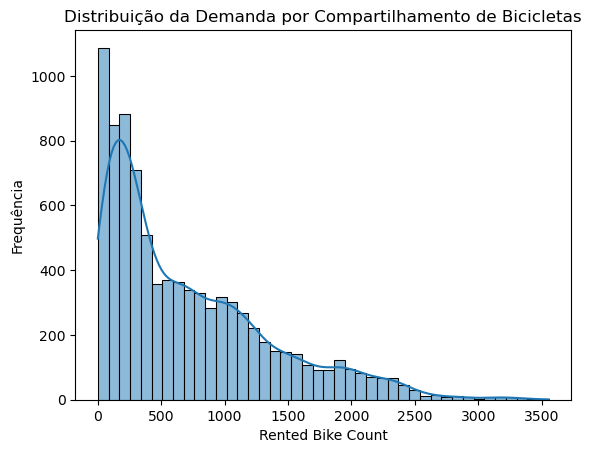

In [9]:
sns.histplot(df['Rented Bike Count'], kde=True)
plt.title('Distribuição da Demanda por Compartilhamento de Bicicletas')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequência')
plt.show()

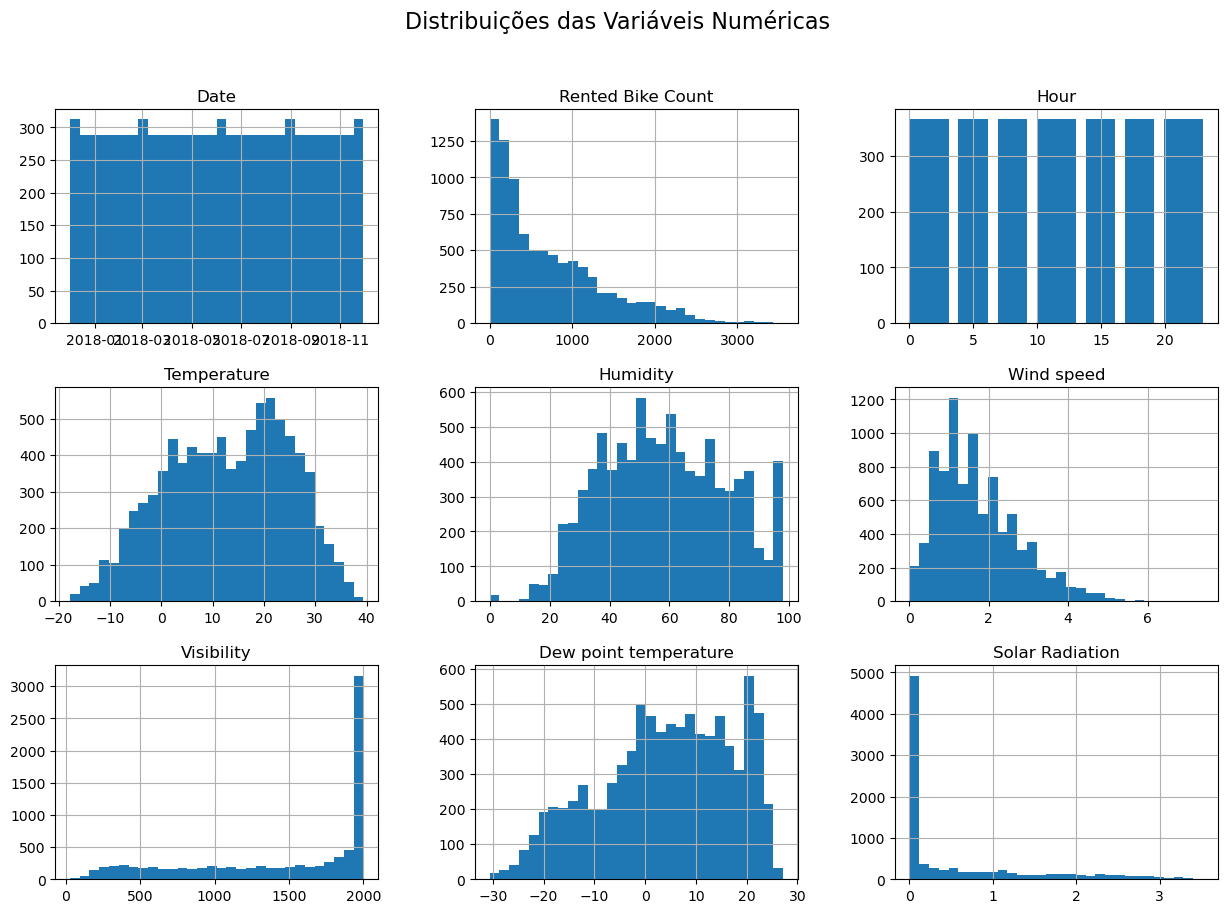

In [31]:

num_df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribuições das Variáveis Numéricas', fontsize=16)
plt.show()

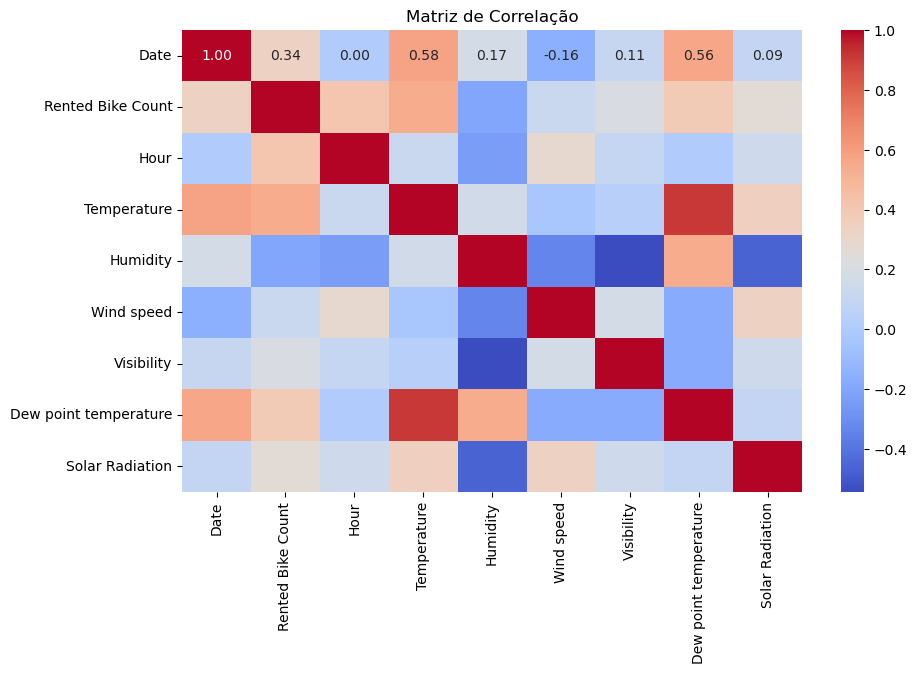

In [37]:
correlation_matrix = num_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()


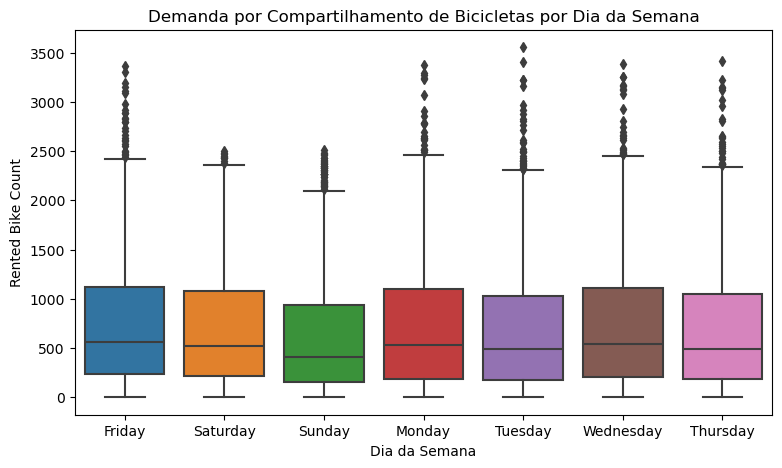

In [39]:

df['Day_of_Week'] = df['Date'].dt.day_name()

plt.figure(figsize=(9,5))
sns.boxplot(x='Day_of_Week', y='Rented Bike Count', data=df)
plt.title('Demanda por Compartilhamento de Bicicletas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Rented Bike Count')
plt.show()

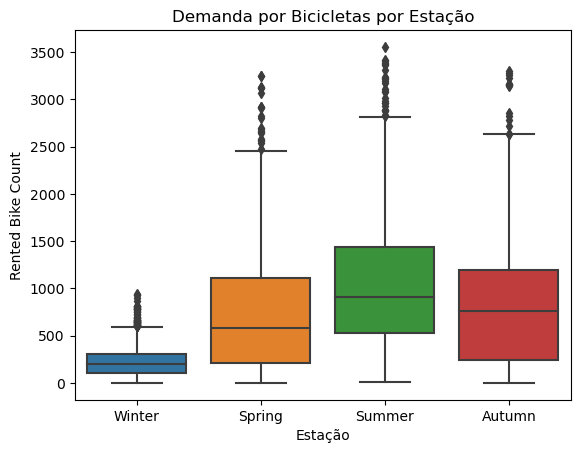

In [ ]:
sns.boxplot(x='Seasons', y='Rented Bike Count', data=df)
plt.title('Demanda por Bicicletas por Estação')
plt.xlabel('Estação')
plt.ylabel('Rented Bike Count')
plt.show()

### Preparação do modelo 